In [80]:
import re
import os
import pandas as pd
from string import punctuation
from textblob import Word 
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import tensorflow_datasets as tfds


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [81]:
# Load the dataset
data = tfds.load('imdb_reviews', split={'train': 'train[:5000]', 'test': 'test[:5000]', 'unsupervised': 'unsupervised[:5000]'})

# Convert the data into pandas DataFrame and decode bytes to string
train_df = tfds.as_dataframe(data['train'])
test_df = tfds.as_dataframe(data['test'])
valid_df = tfds.as_dataframe(data['unsupervised'])

# Decode bytes to string
train_df['text'] = train_df['text'].apply(lambda x: x.decode('utf-8'))
test_df['text'] = test_df['text'].apply(lambda x: x.decode('utf-8'))
valid_df['text'] = valid_df['text'].apply(lambda x: x.decode('utf-8'))

In [82]:
train_df.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5000 non-null   int64 
 1   text    5000 non-null   object
dtypes: int64(1), object(1)
memory usage: 78.3+ KB


In [83]:
test_df.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5000 non-null   int64 
 1   text    5000 non-null   object
dtypes: int64(1), object(1)
memory usage: 78.3+ KB


In [84]:
def transformations(dataframe):
    #HTML Tags removal
    dataframe['text'] = dataframe['text'].apply(lambda words: re.sub('<.*?>','',words)) 
    #Word Tokenization
    dataframe['text'] = dataframe['text'].apply(word_tokenize)
    #Lower case conversion
    dataframe['text'] = dataframe['text'].apply(lambda words: [x.lower() for x in words])
    #Punctuation removal
    dataframe['text'] = dataframe['text'].apply(lambda words: [x for x in words if not x in punctuation])
    #Number removal
    dataframe['text'] = dataframe['text'].apply(lambda words: [x for x in words if not x.isdigit()])
    #Stopword removal
    dataframe['text'] = dataframe['text'].apply(lambda words: [x for x in words if x not in stopwords.words('english')])
    #Frequent word removal
    temp = dataframe['text'].apply(lambda words: " ".join(words))
    freq = pd.Series(temp).value_counts()[:10]
    dataframe['text'] = dataframe['text'].apply(lambda words: [x for x in words if x not in freq.keys()])
    #Lemmatization
    dataframe['text'] = dataframe['text'].apply(lambda words: " ".join([Word(x).lemmatize() for x in words]))
    return dataframe

In [85]:
train_df = transformations(train_df)
test_df = transformations(test_df)

In [86]:
train_df.head()


,label,text
0,0,absolutely terrible movie n't lured christophe...
1,0,known fall asleep film usually due combination...
2,0,mann photograph alberta rocky mountain superb ...
3,1,kind film snowy sunday afternoon rest world go...
4,1,others mentioned woman go nude film mostly abs...


In [87]:
test_df.head()

,label,text
0,1,film make career george romero night living de...
1,1,blackly comic tale down-trodden priest nazarin...
2,0,scary movie 1-4 epic movie date movie meet spa...
3,0,poor shirley maclaine try hard lend gravitas m...
4,1,former erasmus student enjoyed film much reali...


Positive Words


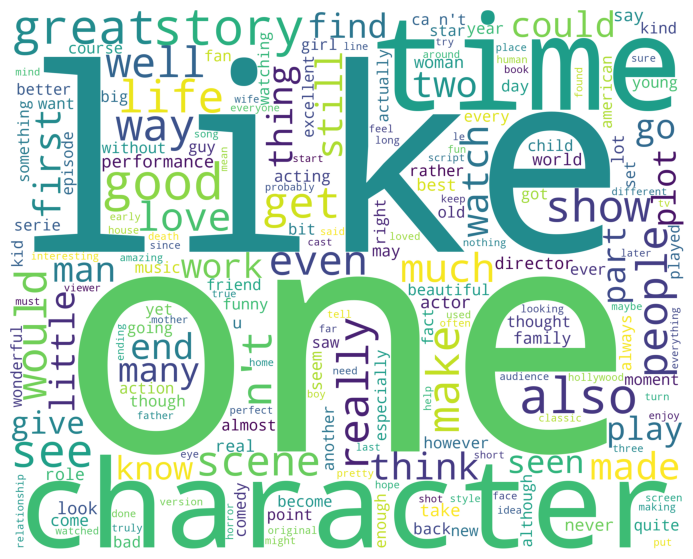

Negative Words


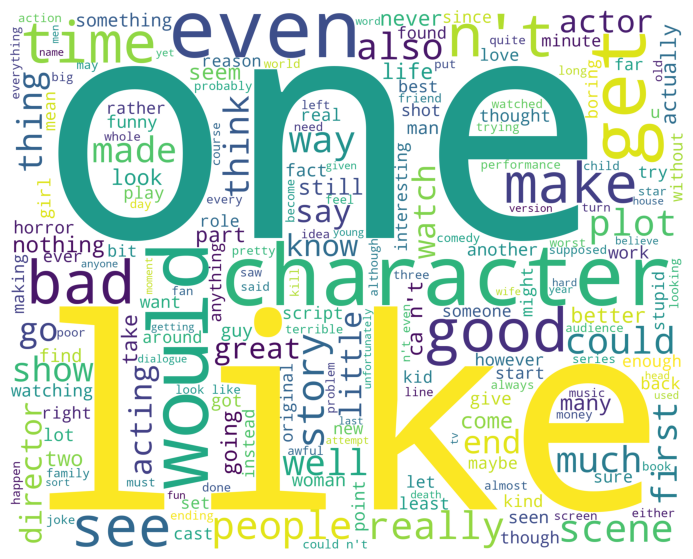

In [88]:
#Create Word Clouds for positive & negative reviews
from wordcloud import WordCloud
positivedata = train_df[ train_df['label'] == 1]
positivedata =positivedata['text']
negdata = train_df[train_df['label'] == 0]
negdata= negdata['text']

def wordcloud_draw(data, color = 'white'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                              if(word!='movie' and word!='film')
                            ])
    wordcloud = WordCloud(stopwords=stopwords.words('english'),
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(10, 7))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive Words")
wordcloud_draw(positivedata)
print("Negative Words")
wordcloud_draw(negdata)

In [89]:
X_train = train_df.text
Y_train = train_df.label

X_valid = valid_df.text
Y_valid = valid_df.label

X_test = test_df.text
Y_test = test_df.label

In [90]:
#Creating a Pipeline
clf = Pipeline(steps =[
('preprocessing', CountVectorizer()),
('classifier', LogisticRegression(dual=False,max_iter=2000))
])#Fitting the model
clf.fit(X_train, Y_train)

Pipeline(steps=[('preprocessing', CountVectorizer()),
                ('classifier', LogisticRegression(max_iter=2000))])

In [91]:
#Calculation model Scores
print(clf.score(X_valid, Y_valid))
print(clf.score(X_test,Y_test))




0.0
0.8528


In [92]:
p = clf.predict(X_test) 
print(p)

[1 1 0 ... 1 0 1]


In [93]:
#Finding number of +ve & -ve classifications
print(f'Number of reviews classified as Poitive: {list(p).count(1)}')
print(f'Number of reviews classified as Negative: {list(p).count(0)}')

Number of reviews classified as Poitive: 2565
Number of reviews classified as Negative: 2435
